In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from itertools import combinations

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## Similarity Network Correlation Analysis

In [75]:
# Get current working directory
print("Current working directory:", os.getcwd())

# Construct absolute paths
base_dir = os.path.dirname(os.getcwd())  # Go up one level from notebooks
data_path = os.path.join(base_dir, 'results_run7')

si_path = os.path.join(data_path, 'small_matrix_si_influence.csv')
sir_path = os.path.join(data_path, 'small_matrix_sir_influence.csv')

print("SI file exists:", os.path.exists(si_path))
print("SIR file exists:", os.path.exists(sir_path))

# Then load with these paths
si_data = pd.read_csv(si_path)
sir_data = pd.read_csv(sir_path)

print("SI Data columns:", si_data.columns.tolist())
print("SIR Data columns:", sir_data.columns.tolist())
print(f"SI data shape: {si_data.shape}")
print(f"SIR data shape: {sir_data.shape}")

# Since network metrics are the same, we'll use the ones from SI data
# Rename columns to avoid conflicts during merge
si_data_renamed = si_data.rename(columns={
    'strength': 'strength',
    'pagerank': 'pagerank',
    'eigenvector_centrality': 'eigenvector_centrality',
    'approximate_current_flow_betweenness': 'current_flow_betweenness',
    'clustering': 'clustering'
})

sir_data_renamed = sir_data.rename(columns={ # Temporary, will be dropped
    'strength': 'strength_sir',  
    'pagerank': 'pagerank_sir',
    'eigenvector_centrality': 'eigenvector_centrality_sir',
    'approximate_current_flow_betweenness': 'current_flow_betweenness_sir',
    'clustering': 'clustering_sir'
})

# Merge the datasets on user_id
merged_data = pd.merge(si_data_renamed, sir_data_renamed, on='user_id', suffixes=('', '_sir'))

# Drop the duplicate network metrics from SIR data since they're the same
merged_data = merged_data.drop(['strength_sir', 'pagerank_sir', 'eigenvector_centrality_sir', 'current_flow_betweenness_sir', 'clustering_sir'], axis=1)

# Load alternative current flow betweenness data
merged_data = merged_data.drop('current_flow_betweenness', axis=1)
current_flow_betweenness = pd.read_csv('data/current_flow_betweenness.csv')
merged_data = pd.merge(merged_data, current_flow_betweenness, on='user_id')


print(f"Merged data shape: {merged_data.shape}")
print("\nFirst few rows of merged data:")
print(merged_data.head())

Current working directory: c:\Users\danie\Documents\Local_Gits\complex-networks\notebooks
SI file exists: True
SIR file exists: True
SI Data columns: ['user_id', 'time_to_10', 'time_to_25', 'time_to_50', 'time_to_90', 'std_time_10', 'std_time_25', 'std_time_50', 'final_size', 'strength', 'pagerank', 'eigenvector_centrality', 'approximate_current_flow_betweenness', 'clustering']
SIR Data columns: ['user_id', 'final_outbreak', 'std_outbreak', 'attack_rate', 'epidemic_probability', 'peak_infection', 'time_to_peak', 'duration', 'R0', 'growth_rate', 'strength', 'pagerank', 'eigenvector_centrality', 'approximate_current_flow_betweenness', 'clustering']
SI data shape: (1157, 14)
SIR data shape: (1157, 15)
Merged data shape: (1157, 24)

First few rows of merged data:
   user_id  time_to_10  time_to_25  time_to_50  time_to_90  std_time_10  \
0      136         1.0         1.0         1.0         1.0          0.0   
1      172         1.0         1.0         1.0         1.0          0.0   
2    

In [76]:
# Define the metrics we want to analyze
si_metrics = ['time_to_10', 'time_to_50', 'time_to_90', 'final_size']

sir_metrics = ['attack_rate', 'time_to_peak', 'R0', 'growth_rate']

network_metrics = ['strength', 'eigenvector_centrality', 'current_flow_betweenness', 'clustering']  # Same for both models

In [77]:
# Function to calculate correlations
def calculate_correlations(data, metrics1, metrics2):
    """Calculate correlations between two sets of metrics"""
    correlations = []
    
    for metric1 in metrics1:
        for metric2 in metrics2:
            # Remove any rows with NaN values for these two metrics
            clean_data = data[[metric1, metric2]].dropna()
            corr, p_value = pearsonr(clean_data[metric1], clean_data[metric2])
                
            correlations.append({
                'metric1': metric1,
                'metric2': metric2,
                'correlation': corr,
                'p_value': p_value,
                'n_samples': len(clean_data)
            })
    
    return pd.DataFrame(correlations)

# Calculate correlations with network metrics as predictors (x-axis)
print("Calculating correlations: Network metrics vs SI outcomes...")
network_si_corr = calculate_correlations(merged_data, network_metrics, si_metrics)
network_si_corr_sorted = network_si_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 Network-SI correlations (absolute value):")
print(network_si_corr_sorted.head(10).to_string(index=False))

print("\nCalculating correlations: Network metrics vs SIR outcomes...")
network_sir_corr = calculate_correlations(merged_data, network_metrics, sir_metrics)
network_sir_corr_sorted = network_sir_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 Network-SIR correlations (absolute value):")
print(network_sir_corr_sorted.head(10).to_string(index=False))

Calculating correlations: Network metrics vs SI outcomes...

Top 10 Network-SI correlations (absolute value):
                 metric1    metric2  correlation       p_value  n_samples
  eigenvector_centrality final_size     0.749054 9.372712e-209       1157
              clustering time_to_90     0.726890 1.033385e-190       1157
              clustering time_to_50     0.725183 2.136563e-189       1157
  eigenvector_centrality time_to_90     0.713660 9.071274e-181       1157
              clustering final_size     0.711616 2.775017e-179       1157
                strength final_size     0.708626 3.923335e-177       1157
current_flow_betweenness final_size     0.687938 5.689286e-163       1157
                strength time_to_90     0.673677 6.970514e-154       1157
current_flow_betweenness time_to_90     0.662296 5.463482e-147       1157
  eigenvector_centrality time_to_50     0.611793 9.743113e-120       1157

Calculating correlations: Network metrics vs SIR outcomes...

Top 10 Networ

Creating separate heatmaps for SI and SIR simulation outcomes...


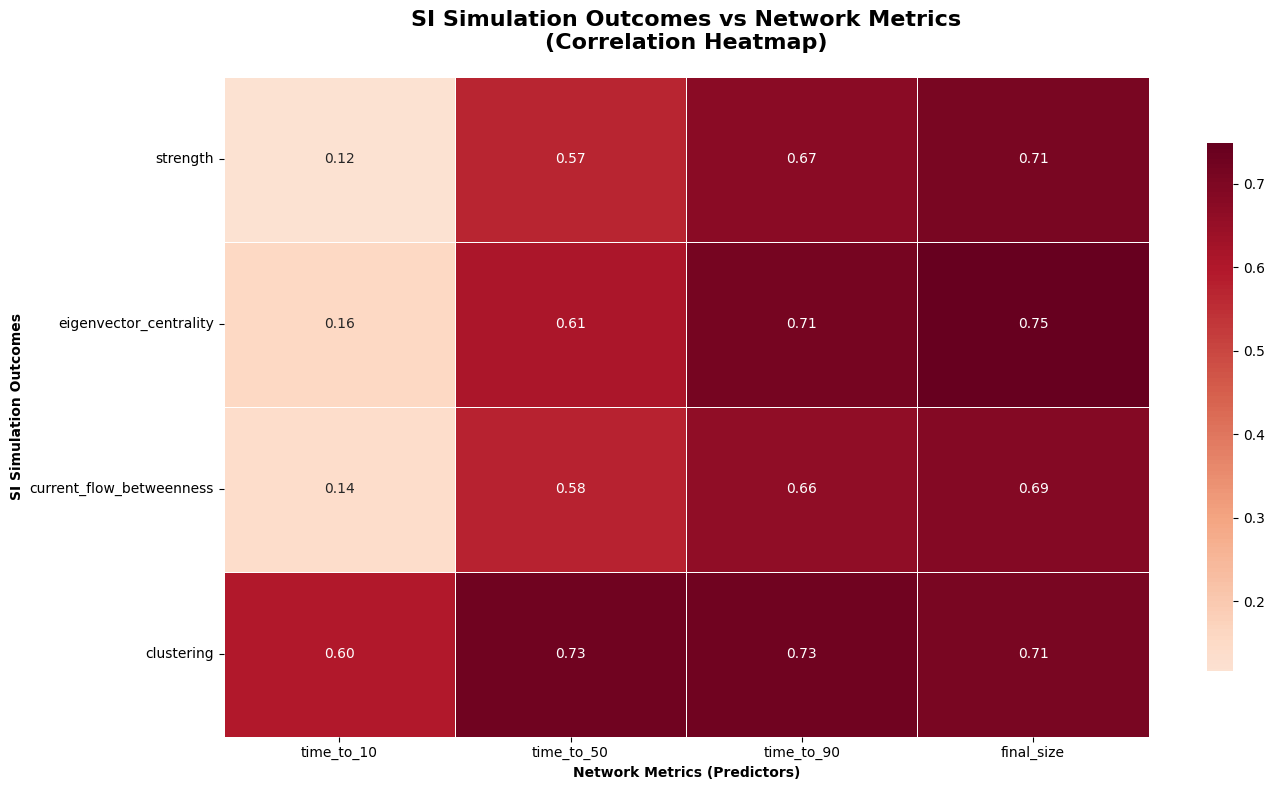

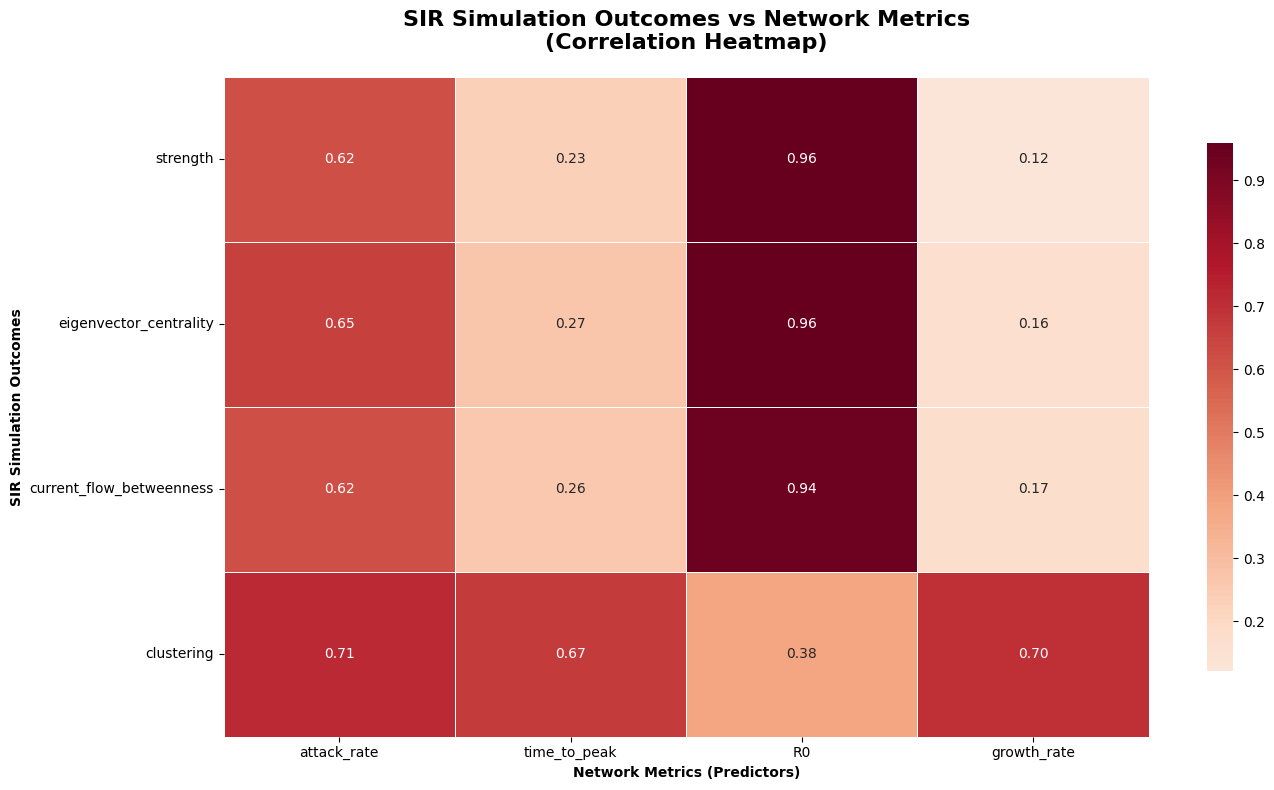

In [82]:
# Create separate heatmaps for SI and SIR metrics
print("Creating separate heatmaps for SI and SIR simulation outcomes...")

# Create SI heatmap
# Calculate correlation matrix for SI metrics
si_corr_data = merged_data[network_metrics + si_metrics]
si_corr_matrix = si_corr_data.corr()

# Extract only the cross-correlations (network metrics vs SI outcomes)
si_cross_corr = si_corr_matrix.loc[network_metrics, si_metrics]

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(si_cross_corr, annot=True, cmap='RdBu_r', center=0,
            square=False, fmt='.2f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 10}, linewidths=0.5)

plt.title('SI Simulation Outcomes vs Network Metrics\n(Correlation Heatmap)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Network Metrics (Predictors)', fontweight='bold')
plt.ylabel('SI Simulation Outcomes', fontweight='bold')
plt.tight_layout()
plt.show()

# Create SIR heatmap
# Calculate correlation matrix for SIR metrics
sir_corr_data = merged_data[network_metrics + sir_metrics]
sir_corr_matrix = sir_corr_data.corr()

# Extract only the cross-correlations (network metrics vs SIR outcomes)
sir_cross_corr = sir_corr_matrix.loc[network_metrics, sir_metrics]

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(sir_cross_corr, annot=True, cmap='RdBu_r', center=0,
            square=False, fmt='.2f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 10}, linewidths=0.5)

plt.title('SIR Simulation Outcomes vs Network Metrics\n(Correlation Heatmap)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Network Metrics (Predictors)', fontweight='bold')
plt.ylabel('SIR Simulation Outcomes', fontweight='bold')
plt.tight_layout()
plt.show()

## Combining Network Metrics

In [79]:
# Scale all data
scaler = StandardScaler()
all_metrics = network_metrics + si_metrics + sir_metrics
scaled_data = merged_data[all_metrics].copy()
scaled_data[all_metrics] = scaler.fit_transform(scaled_data[all_metrics])

# Create all pairs of network metrics
network_pairs = list(combinations([m for m in network_metrics if m in scaled_data.columns], 2))
print(f"Created {len(network_pairs)} network metric pairs")

# Calculate correlations for pairs with simulation metrics
def calculate_pair_correlations(scaled_df, network_pairs, outcomes, model_name, top_n=20):
    correlations = []
    for pred1, pred2 in network_pairs:
        # Create combined metric (multiplicative interaction)
        pair_name = f"{pred1}×{pred2}"
        combined_metric = scaled_df[pred1] * scaled_df[pred2]
        
        for outcome in outcomes:
            if outcome in scaled_df.columns:
                clean_data = pd.DataFrame({
                    'combined': combined_metric,
                    'outcome': scaled_df[outcome]
                }).dropna()
                
                if len(clean_data) > 1:
                    corr, p_val = pearsonr(clean_data['combined'], clean_data['outcome'])
                    correlations.append({
                        'predictor_pair': pair_name,
                        'predictor1': pred1,
                        'predictor2': pred2,
                        'outcome': outcome,
                        'correlation': corr,
                        'abs_correlation': abs(corr),
                        'p_value': p_val,
                        'model': model_name
                    })
    return pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False).head(top_n)

# Get top correlations for pairs
top_si_pairs = calculate_pair_correlations(scaled_data, network_pairs, si_metrics, 'SI', 20)
top_sir_pairs = calculate_pair_correlations(scaled_data, network_pairs, sir_metrics, 'SIR', 20)

# Display results
print("\nTOP 10 SI CORRELATIONS (Network Metric Pairs):")
print("="*80)
for idx, row in top_si_pairs.iterrows():
    print(f"{idx+1:2d}. {row['predictor_pair']:45} → {row['outcome']:20} r = {row['correlation']:7.3f} (p = {row['p_value']:.2e})")

print("\nTOP 10 SIR CORRELATIONS (Network Metric Pairs):")
print("="*80)
for idx, row in top_sir_pairs.iterrows():
    print(f"{idx+1:2d}. {row['predictor_pair']:45} → {row['outcome']:20} r = {row['correlation']:7.3f} (p = {row['p_value']:.2e})")


Created 6 network metric pairs

TOP 10 SI CORRELATIONS (Network Metric Pairs):
 4. strength×eigenvector_centrality               → final_size           r =  -0.912 (p = 0.00e+00)
16. eigenvector_centrality×current_flow_betweenness → final_size           r =  -0.909 (p = 0.00e+00)
 8. strength×current_flow_betweenness             → final_size           r =  -0.895 (p = 0.00e+00)
15. eigenvector_centrality×current_flow_betweenness → time_to_90           r =  -0.892 (p = 0.00e+00)
 3. strength×eigenvector_centrality               → time_to_90           r =  -0.883 (p = 0.00e+00)
 7. strength×current_flow_betweenness             → time_to_90           r =  -0.878 (p = 0.00e+00)
14. eigenvector_centrality×current_flow_betweenness → time_to_50           r =  -0.825 (p = 4.99e-289)
 6. strength×current_flow_betweenness             → time_to_50           r =  -0.810 (p = 4.52e-270)
 2. strength×eigenvector_centrality               → time_to_50           r =  -0.798 (p = 5.87e-256)
10. strength

## Similarity vs. Temporal Analysis

In [80]:
# Load SIS AUC data and calculate correlations
sis_auc_data = pd.read_csv("data/SIS_AUC.csv")
print(f"SIS AUC data shape: {sis_auc_data.shape}")
print(f"SIS AUC columns: {sis_auc_data.columns.tolist()}")

# Merge with existing data
merged_with_sis = pd.merge(merged_data, sis_auc_data, on='user_id', how='inner')
print(f"Merged data with SIS AUC shape: {merged_with_sis.shape}")

# Scale all data for fair comparison
scaler = StandardScaler()
all_metrics_with_sis = network_metrics + si_metrics + sir_metrics + ['sis_auc']
scaled_data_with_sis = merged_with_sis[all_metrics_with_sis].copy()
scaled_data_with_sis[all_metrics_with_sis] = scaler.fit_transform(scaled_data_with_sis[all_metrics_with_sis])

# Calculate correlations
def calculate_correlations_with_target(scaled_df, predictors, target, target_name):
    correlations = []
    for predictor in predictors:
        if predictor in scaled_df.columns:
            clean_data = scaled_df[[predictor, target]].dropna()
            if len(clean_data) > 1:
                corr, p_val = pearsonr(clean_data[predictor], clean_data[target])
                correlations.append({
                    'predictor': predictor,
                    'correlation': corr,
                    'abs_correlation': abs(corr),
                    'p_value': p_val,
                    'target': target_name
                })
    return pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

# Table 1: Correlations with Network Metrics
print("\n" + "="*70)
print("TABLE 1: SIS AUC vs NETWORK METRICS")
print("="*70)
network_correlations = calculate_correlations_with_target(
    scaled_data_with_sis, 
    network_metrics, 
    'sis_auc', 
    'SIS_AUC'
)
print(f"{'Network Metric':<35} {'Correlation':<12} {'P-value':<12} {'Strength':<10}")
print("-" * 70)
for idx, row in network_correlations.iterrows():
    strength = "STRONG" if abs(row['correlation']) > 0.7 else "MODERATE" if abs(row['correlation']) > 0.5 else "WEAK" if abs(row['correlation']) > 0.3 else "VERY WEAK"
    print(f"{row['predictor']:<35} {row['correlation']:>11.3f} {row['p_value']:>11.2e} {strength:>10}")

# Table 2: Correlations with SI Simulation Metrics
print("\n" + "="*70)
print("TABLE 2: SIS AUC vs SI SIMULATION METRICS")
print("="*70)
si_correlations = calculate_correlations_with_target(
    scaled_data_with_sis, 
    si_metrics, 
    'sis_auc', 
    'SIS_AUC'
)
print(f"{'SI Metric':<35} {'Correlation':<12} {'P-value':<12} {'Strength':<10}")
print("-" * 70)
for idx, row in si_correlations.iterrows():
    strength = "STRONG" if abs(row['correlation']) > 0.7 else "MODERATE" if abs(row['correlation']) > 0.5 else "WEAK" if abs(row['correlation']) > 0.3 else "VERY WEAK"
    print(f"{row['predictor']:<35} {row['correlation']:>11.3f} {row['p_value']:>11.2e} {strength:>10}")

# Table 3: Correlations with SIR Simulation Metrics
print("\n" + "="*70)
print("TABLE 3: SIS AUC vs SIR SIMULATION METRICS")
print("="*70)
sir_correlations = calculate_correlations_with_target(
    scaled_data_with_sis, 
    sir_metrics, 
    'sis_auc', 
    'SIS_AUC'
)
print(f"{'SIR Metric':<35} {'Correlation':<12} {'P-value':<12} {'Strength':<10}")
print("-" * 70)
for idx, row in sir_correlations.iterrows():
    strength = "STRONG" if abs(row['correlation']) > 0.7 else "MODERATE" if abs(row['correlation']) > 0.5 else "WEAK" if abs(row['correlation']) > 0.3 else "VERY WEAK"
    print(f"{row['predictor']:<35} {row['correlation']:>11.3f} {row['p_value']:>11.2e} {strength:>10}")

SIS AUC data shape: (1411, 2)
SIS AUC columns: ['user_id', 'sis_auc']
Merged data with SIS AUC shape: (1157, 25)

TABLE 1: SIS AUC vs NETWORK METRICS
Network Metric                      Correlation  P-value      Strength  
----------------------------------------------------------------------
clustering                               -0.054    6.66e-02  VERY WEAK
current_flow_betweenness                  0.026    3.73e-01  VERY WEAK
strength                                  0.025    4.03e-01  VERY WEAK
eigenvector_centrality                    0.017    5.71e-01  VERY WEAK

TABLE 2: SIS AUC vs SI SIMULATION METRICS
SI Metric                           Correlation  P-value      Strength  
----------------------------------------------------------------------
time_to_50                               -0.022    4.58e-01  VERY WEAK
time_to_90                               -0.022    4.65e-01  VERY WEAK
final_size                               -0.019    5.24e-01  VERY WEAK
time_to_10            